In [1]:
from lmfit.models import GaussianModel
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import pandas as pd

In [2]:
tds = pd.read_pickle("reduced/tds_phase_1.pkl")
tds

,time,tds_image,is_beam_on,l1_chrip_phase,charge
0,2021-02-21 00:30:17.046674013,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 4, 13, ...",True,-7.0,0.24685
1,2021-02-21 00:30:22.084268093,"[[12, 5, 4, 4, 14, 6, 0, 0, 1, 14, 9, 0, 0, 12...",False,-7.0,NaN
2,2021-02-21 00:30:25.301686049,"[[0, 12, 0, 0, 14, 0, 18, 18, 11, 0, 24, 9, 0,...",False,-7.0,NaN
3,2021-02-21 00:30:28.509352922,"[[0, 0, 3, 0, 15, 9, 0, 0, 9, 0, 22, 18, 17, 0...",False,-7.0,NaN
4,2021-02-21 00:30:31.663580894,"[[2, 0, 0, 0, 15, 11, 0, 0, 30, 0, 0, 0, 0, 11...",False,-7.0,NaN
...,...,...,...,...,...
191,2021-02-21 00:41:28.365645170,"[[0, 6, 1, 0, 17, 1, 0, 13, 0, 0, 13, 0, 0, 0,...",True,5.0,0.24900
192,2021-02-21 00:41:31.679569960,"[[0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 25, 0, 0, 0, 1...",True,5.0,0.25455
193,2021-02-21 00:41:34.964040041,"[[0, 0, 0, 0, 22, 11, 0, 0, 0, 1, 26, 0, 0, 7,...",True,5.0,0.25890
194,2021-02-21 00:41:38.410810947,"[[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,5.0,0.24915


In [7]:
background = tds.loc[1:6,"tds_image"].mean()

preprocessed = tds.loc[6:,["l1_chrip_phase","charge","tds_image"]].copy()

# Average all five images per chirp setting
preprocessed = preprocessed.groupby("l1_chrip_phase").apply(np.mean).drop("l1_chrip_phase", axis=1)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(lambda image: image.clip(0, 4095))

# Remove background
remove_background = lambda image: (image - background).clip(0, 4095)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(remove_background)

# Denoise images
def denoise(image):
    denoised = ndimage.uniform_filter(image, size=12)
    denoised[denoised < 0.05 * denoised.max()] = 0
    return denoised

preprocessed["tds_image"] = preprocessed["tds_image"].apply(denoise)

# Extract current profiles
def extract_current_profile(row):
    seconds_per_pixel = 0.0438912 * 10e-12

    view = row["tds_image"].sum(axis=0)
    current = row["charge"] * 10e-9 / seconds_per_pixel * view / view.sum()

    xs = np.arange(len(current))
    model = GaussianModel()
    guess = model.guess(current, x=xs)
    fit = model.fit(current, guess, x=xs)

    low = int(fit.params["center"].value - 4 * fit.params["sigma"].value)
    high = int(fit.params["center"].value + 4 * fit.params["sigma"].value)
    extracted = current[low:high]

    return extracted

preprocessed = preprocessed.apply(extract_current_profile, axis=1)
preprocessed

l1_chrip_phase
-12.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.0    [9.079330720215614, 9.399006934503833, 9.67279...
-10.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-10.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.0     [0.0, 0.9334706779521185, 1.7374869286994412, ...
-7.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-7.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-6.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-3.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-1.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 2.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

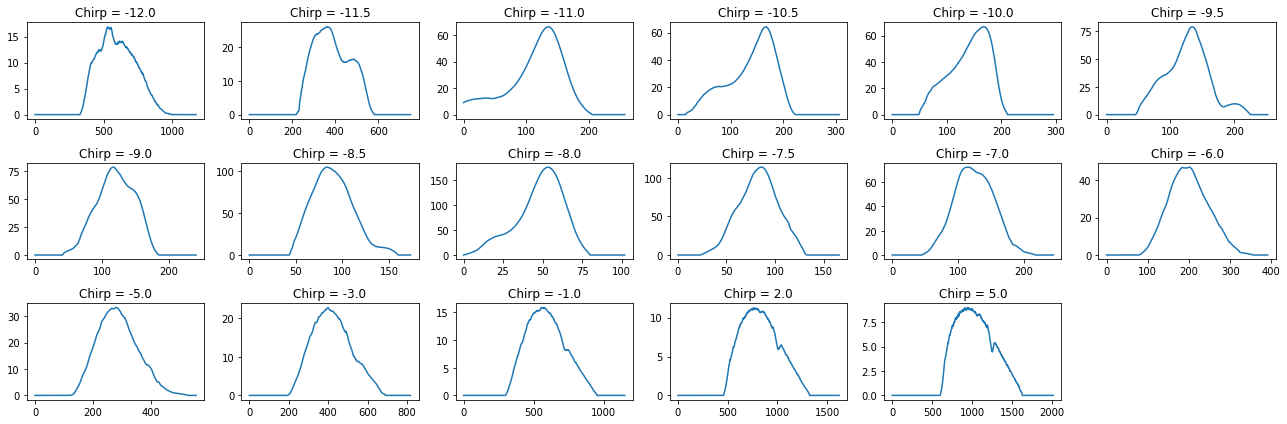

In [133]:
plt.figure(figsize=(18,6))
for i, chirp in enumerate(preprocessed.index.values):
    plt.subplot(3, 6, i+1)
    plt.title(f"Chirp = {chirp}")
    plt.plot(preprocessed[chirp])
plt.tight_layout()
plt.show()

In [9]:
crisp_low = pd.read_pickle("reduced/crisp_low.pkl")
crisp_low

,time,is_beam_on,l1_chrip_phase,bunch_charge,bunch_intensity,bunch_formfactor,detection_limit,grating
0,2021-02-21 01:11:54.228874922,True,-7.0,0.253279,"[[0.0, 0.0013999707], [1.0, 0.002523627], [2.0...","[[0.684283, 1.4530452], [0.6863423, 3.7493443]...","[[0.684283, 1.0198625], [0.6863423, 1.3088695]...",NaN
1,2021-02-21 01:11:58.708318949,True,-12.0,0.164426,"[[0.0, 0.0024111096], [1.0, 0.0010225406], [2....","[[0.684283, 5.03848], [0.6863423, 3.058674], [...","[[0.684283, 2.619609], [0.6863423, 2.2755194],...",NaN
2,2021-02-21 01:11:59.155834198,True,-12.0,0.175028,"[[0.0, -0.00034454287], [1.0, 3.8516522e-05], ...","[[0.684283, -0.6827929], [0.6863423, 0.1092604...","[[0.684283, 2.2036085], [0.6863423, 2.232566],...",NaN
3,2021-02-21 01:11:59.551591873,True,-12.0,0.175334,"[[0.0, 0.0007114549], [1.0, -8.218471e-05], [2...","[[0.684283, 1.5086796], [0.6863423, -0.2494656...","[[0.684283, 2.2036085], [0.6863423, 2.232566],...",NaN
4,2021-02-21 01:12:00.002394915,True,-12.0,0.174987,"[[0.0, 0.0006921916], [1.0, 0.0008636335], [2....","[[0.684283, 1.348622], [0.6863423, 2.408593], ...","[[0.684283, 1.6582719], [0.6863423, 2.4520164]...",NaN
...,...,...,...,...,...,...,...,...
946,2021-02-21 01:19:35.595877171,True,5.0,0.250992,"[[0.0, -0.0005184702], [1.0, -0.00013105865], ...","[[0.684283, -0.50114834], [0.6863423, -0.18133...","[[0.684283, 0.57210094], [0.6863423, 1.2294236...",NaN
947,2021-02-21 01:19:36.016417979,True,5.0,0.252742,"[[0.0, 0.00078865857], [1.0, 0.00089951797], [...","[[0.684283, 0.76443475], [0.6863423, 1.248048]...","[[0.684283, 1.7467835], [0.6863423, 2.493918],...",NaN
948,2021-02-21 01:19:36.525036097,True,5.0,0.247229,"[[0.0, -5.9637492e-05], [1.0, -8.475115e-05], ...","[[0.684283, -0.056538783], [0.6863423, -0.1150...","[[0.684283, 1.7467835], [0.6863423, 2.493918],...",NaN
949,2021-02-21 01:19:36.990997076,True,5.0,0.242415,"[[0.0, -0.0015199165], [1.0, 0.0007720378], [2...","[[0.684283, -1.507832], [0.6863423, 1.0963312]...","[[0.684283, 1.2134799], [0.6863423, 1.3878863]...",NaN


In [20]:
crisp_high = pd.read_pickle("reduced/crisp_high.pkl")
crisp_high

,time,is_beam_on,l1_chrip_phase,bunch_charge,bunch_intensity,bunch_formfactor,detection_limit,grating
0,2021-02-21 01:02:12.055290222,True,-7.0,0.244655,"[[0.0, 0.0027530887], [1.0, 0.0004816452], [2....","[[0.684283, 2.6642845], [0.6863423, 0.6672025]...","[[0.684283, 1.0908662], [0.6863423, 1.6108732]...",NaN
1,2021-02-21 01:02:16.552965164,True,-12.0,0.181003,"[[0.0, 7.7088116e-05], [1.0, 6.8528548e-06], [...","[[0.684283, 0.14918189], [0.6863423, 0.0189832...","[[0.684283, 2.3185298], [0.6863423, 3.399256],...",NaN
2,2021-02-21 01:02:16.978017092,True,-12.0,0.179927,"[[0.0, 0.0040156604], [1.0, 0.0022994007], [2....","[[0.684283, 7.364043], [0.6863423, 6.0359282],...","[[0.684283, 2.3185298], [0.6863423, 3.399256],...",NaN
3,2021-02-21 01:02:17.453599930,True,-12.0,0.169350,"[[0.0, 0.0013958574], [1.0, 0.00097566406], [2...","[[0.684283, 2.6741476], [0.6863423, 2.6755598]...","[[0.684283, 2.3185298], [0.6863423, 3.399256],...",NaN
4,2021-02-21 01:02:17.877995014,True,-12.0,0.173881,"[[0.0, -0.001659313], [1.0, 0.0009868232], [2....","[[0.684283, -3.1175277], [0.6863423, 2.6539419...","[[0.684283, 2.614631], [0.6863423, 3.4196017],...",NaN
...,...,...,...,...,...,...,...,...
946,2021-02-21 01:09:56.719449043,True,5.0,0.248720,"[[0.0, -0.00063984183], [1.0, -0.0005403444], ...","[[0.684283, -0.62241614], [0.6863423, -0.75240...","[[0.684283, 0.82110345], [0.6863423, 1.5778912...",NaN
947,2021-02-21 01:09:57.181535959,True,5.0,0.247885,"[[0.0, 0.0022795394], [1.0, -0.00024948677], [...","[[0.684283, 2.2379296], [0.6863423, -0.3506040...","[[0.684283, 1.3706772], [0.6863423, 1.7941101]...",NaN
948,2021-02-21 01:09:57.600939989,True,5.0,0.247003,"[[0.0, 7.7088116e-05], [1.0, 6.8528548e-06], [...","[[0.684283, 0.07262466], [0.6863423, 0.0092414...","[[0.684283, 1.3706772], [0.6863423, 1.7941101]...",NaN
949,2021-02-21 01:09:58.071997881,True,5.0,0.240662,"[[0.0, 0.0040156604], [1.0, 0.0022994007], [2....","[[0.684283, 4.0536], [0.6863423, 3.3225276], [...","[[0.684283, 1.1754417], [0.6863423, 1.6734393]...",NaN


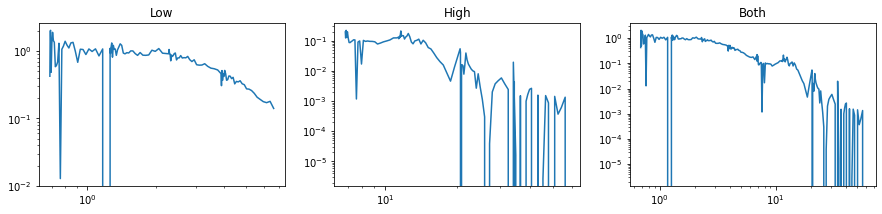

In [81]:
i = 324

plt.figure(figsize=(15,3))

plt.subplot(131)
plt.title("Low")
plt.loglog(crisp_low.loc[i,"bunch_formfactor"][:120,0], crisp_low.loc[i,"bunch_formfactor"][:120,1])

plt.subplot(132)
plt.title("High")
plt.loglog(crisp_high.loc[i,"bunch_formfactor"][120:,0], crisp_high.loc[i,"bunch_formfactor"][120:,1])

# frequencies = np.concatenate([crisp_low.loc[i,"bunch_formfactor"][:120,0], crisp_high.loc[i,"bunch_formfactor"][120:,0]])
frequencies = crisp_low.loc[0,"bunch_formfactor"][:,0]
form_factor = np.concatenate([crisp_low.loc[i,"bunch_formfactor"][:120,1], crisp_high.loc[i,"bunch_formfactor"][120:,1]])

plt.subplot(133)
plt.title("Both")
plt.loglog(frequencies, form_factor)

plt.show()

In [126]:
frequencies = crisp_low.loc[0,"bunch_formfactor"][:,0]

remove_frequencies = lambda data: data[:, 1]
combined = crisp_low[1:][["l1_chrip_phase","bunch_formfactor"]].copy()
combined["form_factor_low"] = combined["bunch_formfactor"].apply(remove_frequencies)
combined.drop("bunch_formfactor", axis=1, inplace=True)
combined["form_factor_high"] = crisp_low[1:]["bunch_formfactor"].apply(remove_frequencies)

def combine_form_factors(row):
    return np.concatenate([row["form_factor_low"][:120], row["form_factor_high"][120:]])

combined["form_factor"] = combined.apply(combine_form_factors, axis=1)
combined.drop(["form_factor_low", "form_factor_high"], axis=1, inplace=True)

combined

,l1_chrip_phase,form_factor
1,-12.0,"[5.03848, 3.058674, -3.2622395, 0.3406048, 1.1..."
2,-12.0,"[-0.6827929, 0.10926041, -0.8235138, 0.5462018..."
3,-12.0,"[1.5086796, -0.24946564, 1.638597, -1.5877224,..."
4,-12.0,"[1.348622, 2.408593, 6.658132, -0.09190628, -1..."
5,-12.0,"[3.3360357, 3.8052037, -6.41254, -0.47265285, ..."
...,...,...
946,5.0,"[-0.50114834, -0.1813336, -1.4195234, 1.071323..."
947,5.0,"[0.76443475, 1.248048, -1.3205945, 1.4769993, ..."
948,5.0,"[-0.056538783, -0.115011886, 1.2003117, -0.509..."
949,5.0,"[-1.507832, 1.0963312, 0.017731637, 0.2107829,..."


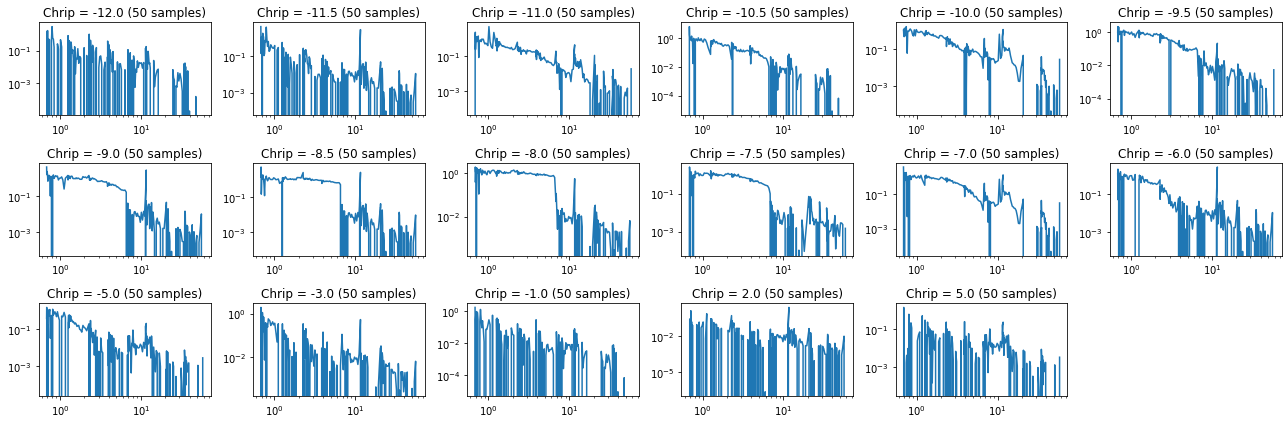

In [135]:
samples_per_chirp = len(combined[combined["l1_chrip_phase"] == chirp])
j = np.random.randint(samples_per_chirp)

plt.figure(figsize=(18,6))
for i, chirp in enumerate(combined["l1_chrip_phase"].unique()):
    plt.subplot(3, 6, i+1)
    plt.title(f"Chrip = {chirp} ({samples_per_chirp} samples)")
    form_factor = combined[combined["l1_chrip_phase"] == chirp].iloc[j]["form_factor"]
    plt.loglog(frequencies, form_factor)
plt.tight_layout()
plt.show()

In [ ]:
# Here is potential to combine every combination if highs and lows of on chirp value
# in order to provide more training data.

In [4]:
# Unite bunch profiles, CRISP high and CRISP low